# Equity Cliquet Option Risk Analysis
This project builds a full Monte Carlo engine in Python to price and evaluate a 5-year equity cliquet option. The contract features capped and floored annual returns, making it path-dependent and analytically intractable. We implement risk-neutral simulations, sensitivity analysis (delta/gamma), and scenario-based P&L evaluation—including regulatory metrics such as VaR and Expected Shortfall under the FRTB framework.

---

### Step 1: Define the Cliquet Option Payoff Structure

This exotic equity derivative pays annually based on the S&P 500’s absolute return, with payoffs clipped between a 3% floor and 7% cap. Returns are calculated year-on-year and scaled by the $10 million notional. The function developed here processes simulated index paths to compute annual payouts for each trajectory.

---

In [1]:
import numpy as np

def cliquet_payoff(prices, floor=0.03, cap=0.07, notional=10e6):
    returns = prices[1:] / prices[:-1] - 1 # compute year-on-year simple returns R_i = S_i / S_{i-1} − 1

    capped   = np.minimum(returns, cap) # apply cap to limit upside returns
    floored  = np.maximum(capped, floor) # apply floor ensure minimum returns

    cashflows = notional * floored # work out the per period cashflow by scaling by the notional

    return cashflows


scenario_prices_5y = np.array([100.0, 105.0,  98.0, 110.0, 115.0, 120.0]) # simulated year-end prices at t=0,1,2,3,4,5

annual_cashflows = cliquet_payoff(scenario_prices_5y, floor=0.03, cap=0.07, notional=1e7)

print("Year-by-year cashflows:", annual_cashflows)

Year-by-year cashflows: [500000.         300000.         700000.         454545.45454545
 434782.60869565]


### Step 2: Monte Carlo Pricing under Risk-Neutral Measure

We simulate thousands of price paths using the Black-Scholes-Merton framework calibrated to market data. The goal is to estimate the fair value of the 5-year cliquet option by computing the discounted expected payoff under risk-neutral dynamics.

---

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Inputs: personal dataset parameters
initial_spot   = 5633.0             # S₀ (index level in points)
mu             = 0.0453             # expected return (4.53%), for real‐world P&L later
sigma          = 0.0978             # annual volatility (9.78%)
short_rate_bp  = 49.44              # risk‐free rate in basis points
r              = short_rate_bp / 10000  # convert basis points to decimal

# Cliquet contract specifications
cap        = 0.07       # 7% annual cap
floor      = 0.03       # 3% annual floor
notional   = 10_000_000 # $10 million notional
tau        = 5          # maturity in years
steps      = 5          # annual fixings
simulations = 100_000   # number of MC paths


# Simulate GBM paths under risk-neutral measure
def BSMScenarios(N, S, r, tau, sigma, steps, seed=None):
    dt    = tau / steps
    rng   = np.random.default_rng(seed)
    Z     = rng.standard_normal((N, steps))
    drift = (r - 0.5 * sigma**2) * dt
    diff  = sigma * np.sqrt(dt) * Z
    log_inc   = drift + diff
    log_paths = np.concatenate([np.zeros((N,1)), log_inc.cumsum(axis=1)], axis=1)
    return S * np.exp(log_paths)
# The BSMScenarios function simulates N risk-neutral price paths using the BSM model.
# Each path follows geometric Brownian motion over 'step' years, with returns given by: Sₜ₊₁ = Sₜ·exp((r–½σ²)Δt + σ√Δt·Z)


# Calculate cliquet payoff for a single simulated path
def CliquetPayoff(path, cap, floor, notional):
    rets    = path[1:] / path[:-1] - 1 # simple annual returns
    clipped = np.minimum(np.maximum(rets, floor), cap) # apply floor and cap
    return notional * clipped.sum() # scale by notional and sum


# Monte Carlo pricing of the cliquet option
def MC_CliquetPrice(N, S, r, tau, sigma, steps, cap, floor, notional, seed=42):
    scenarios = BSMScenarios(N, S, r, tau, sigma, steps, seed) # simulate N paths
    coupon_pvs = np.apply_along_axis(CliquetPayoff, 1, scenarios, cap, floor, notional) # compute payoffs for each path
    coupon_price = np.exp(-r * tau) * coupon_pvs.mean() # discount to PV
    principal_price = notional * np.exp(-r * tau)   # PV of $10m at T=τ
    return coupon_price + principal_price

# Run the pricing function with inputs
price = MC_CliquetPrice(simulations, initial_spot, r, tau, sigma, steps, cap, floor, notional, seed=123)

print(f"Estimated cliquet option price: ${price:,.2f}")

Estimated cliquet option price: $11,825,735.78


### Risk-Neutral Index Path Simulation

To validate the simulation engine, we generate sample geometric Brownian motion (GBM) paths under the risk-neutral measure. This step provides a sanity check before pricing and risk analysis.

---

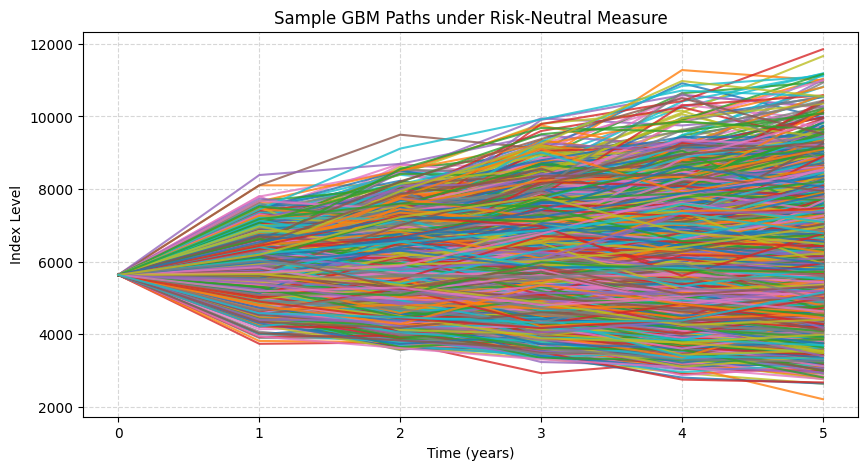

In [3]:
# Sample GBM Paths under Risk-Neutral Measure
import seaborn as sns

sample_N = 10000
sample_paths = BSMScenarios(sample_N, initial_spot, r, tau, sigma, steps, seed=2025)

plt.figure(figsize=(10, 5))
for i in range(sample_N):
    plt.plot(np.linspace(0, tau, steps+1), sample_paths[i], lw=1.5, alpha=0.8)
plt.title("Sample GBM Paths under Risk-Neutral Measure")
plt.xlabel("Time (years)")
plt.ylabel("Index Level")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

### Payoff Distribution Analysis

Here we simulate a large batch of paths and visualize the resulting cliquet payoffs using a histogram. This helps illustrate the effects of the floor/cap structure and the path-dependence inherent in the contract.

---

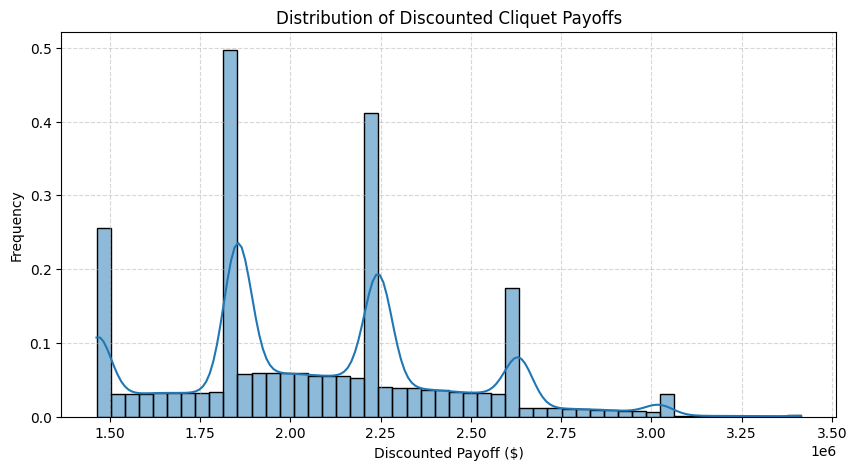

In [4]:
sim_paths = BSMScenarios(simulations, initial_spot, r, tau, sigma, steps, seed=123) #simualte set of paths
raw_payoffs = np.apply_along_axis(CliquetPayoff, 1, sim_paths, cap, floor, notional) #compute cliquet payoff for each path
disc_payoffs = np.exp(-r * tau) * raw_payoffs #discount back to PV

# Plot the distribution as a histogram
plt.figure(figsize=(10, 5))
sns.histplot(disc_payoffs, bins=50, kde=True, stat="frequency", edgecolor='black')
plt.title("Distribution of Discounted Cliquet Payoffs")
plt.xlabel("Discounted Payoff ($)")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

### Step 3: Estimate option sensitivities (Delta and Gamma)

---

I use central finite differences to estimate how the cliquet price changes when the spot index is bumped slightly up or down. This approximates the delta and gamma using the Monte Carlo pricing function from earlier.



In [5]:
import numpy as np

def MC_CliquetGreeks(N, S0, r, tau, sigma, steps, cap, floor, notional, bump=0.01, seed=42):
    V0     = MC_CliquetPrice(N, S0, r, tau, sigma, steps, cap, floor, notional, seed=seed) #base price at orginal spot
    # Up/down bumped spots
    S_up   = S0 * (1 + bump)
    S_down = S0 * (1 - bump)
    V_up   = MC_CliquetPrice(N, S_up, r, tau, sigma, steps, cap, floor, notional, seed=seed)
    V_down = MC_CliquetPrice(N, S_down, r, tau, sigma, steps, cap, floor, notional, seed=seed)

    delta = (V_up - V_down) / (2 * S0 * bump)
    gamma = (V_up - 2 * V0 + V_down) / (S0**2 * bump**2)
    return delta, gamma

# Try a few different bump sizes and print the results
bump_list = [0.001, 0.01, 0.10]
for eps in bump_list:
    d, g = MC_CliquetGreeks(simulations, initial_spot, r, tau, sigma, steps, cap, floor, notional, bump=eps, seed=123)
    print(f"Bump = {eps * 100:.1f}% → Delta = {d:.6f}, Gamma = {g:.6f}")

Bump = 0.1% → Delta = 0.000000, Gamma = 0.000000
Bump = 1.0% → Delta = 0.000000, Gamma = 0.000000
Bump = 10.0% → Delta = 0.000000, Gamma = 0.000000


### Step 4: Visualise the cliquet payoff using option replication

---

A cliquet payoff can be thought of as a portfolio of simpler products. Specifically, a fixed floor and a capped upside, which resembles a bull spread strategy. In this step, I recreate the payoff diagram using a long call struck at the floor level (3%) and a short call struck at the cap level (7%), scaled by the $10 million notional.

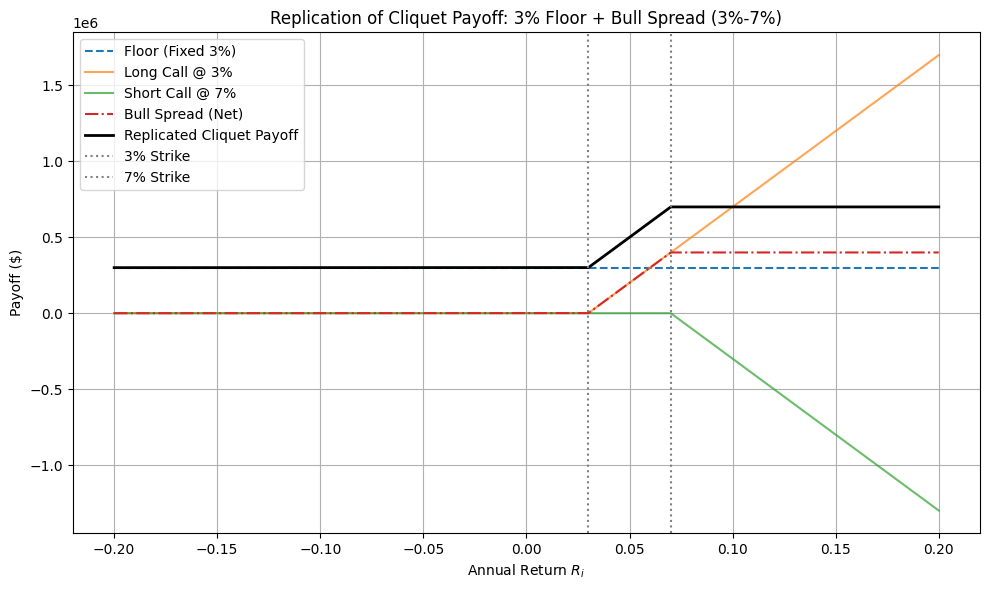

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def plot_cliquet_replication_diagram(floor=0.03, cap=0.07, notional=1e7):
    R = np.linspace(-0.2, 0.2, 500)  # x-axis contains returns from -20% to +20%

    # Build payoff components:
    long_call = np.maximum(R - floor, 0) #long call payoff at 3%
    short_call = np.maximum(R - cap, 0) #short call payoff at 7%
    bull_spread = long_call - short_call #net bull spread payoff

    # Total replicated payoff = fixed 3% + bull spread
    total_payoff_rate = floor + bull_spread
    total_payoff = notional * total_payoff_rate

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(R, notional * floor * np.ones_like(R), label='Floor (Fixed 3%)', linestyle='--')
    plt.plot(R, notional * long_call, label='Long Call @ 3%', alpha=0.7)
    plt.plot(R, -notional * short_call, label='Short Call @ 7%', alpha=0.7)
    plt.plot(R, notional * bull_spread, label='Bull Spread (Net)', linestyle='-.')
    plt.plot(R, total_payoff, label='Replicated Cliquet Payoff', linewidth=2, color='black')

    plt.axvline(floor, color='grey', linestyle=':', label='3% Strike')
    plt.axvline(cap, color='grey', linestyle=':', label='7% Strike')

    plt.title("Replication of Cliquet Payoff: 3% Floor + Bull Spread (3%-7%)")
    plt.xlabel("Annual Return $R_i$")
    plt.ylabel("Payoff ($)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_cliquet_replication_diagram()


Following the replication from earlier, I now use discounted forward-starting call options to value each component of the cliquet. This includes:


* A fixed floor leg that pays 3% each year
* A bull spread made from forward calls struck at 3% and 7%
* The principal returned at maturity

This approach helps to break down the total value of the contract into interpretable pieces, without a full MC simulation.



In [7]:
from scipy.stats import norm

#floor leg:
floor_leg = notional * floor * sum(np.exp(-r * k) for k in range(1,6)) #fixed 3% floor coupon paid each year and discounted

# bull spread leg:

# define value of a 1-year forward-starting call maturing at year k
def forward_call(K, k):
    P0  = np.exp(-r*(k-1)) #discount to time k-1
    P1  = np.exp(-r*k) #discount to time k
    vol = sigma * np.sqrt(1) #assume 1 year forward option
    d1  = (np.log(1/K) + 0.5*vol**2)/vol
    d2  = d1 - vol
    return P0*norm.cdf(d1) - K*P1*norm.cdf(d2)

# value of bull spread (long call at floor and short call at cap), repated for each of the 5 years
bull_leg = notional * sum(
    forward_call(1+floor, k) - forward_call(1+cap, k)
    for k in range(1,6))

principal_leg = notional * np.exp(-r * tau) #discounting principal repaid at maturity
cliquet_price_decomp = principal_leg + floor_leg + bull_leg #total decomposed value


print(f"Decomposed cliquet price: ${cliquet_price_decomp:,.2f}")


Decomposed cliquet price: $11,845,942.80


### Step 5: Simulate 1-Year P&L and compute risk measures

---

Now that the option is priced, I simulate the P&L from holding a short position in holding this cliquet contract over a year. This uses the real-world drift rate μ instead of the risk-neutral rate, since we're measuring actual profit/loss.

I then calculate the value of the remaining 4-year contract at t=1 (V1) and compare it to the original value (V0) to get the P&L. The process is repeated for 2000 market scenarios.

Finally, I plot the P&L distributions (naked and delta-hedged) and compute the 99% Value-at-Risk and Expected Shortfall, which are two standard regulatory risk measures.


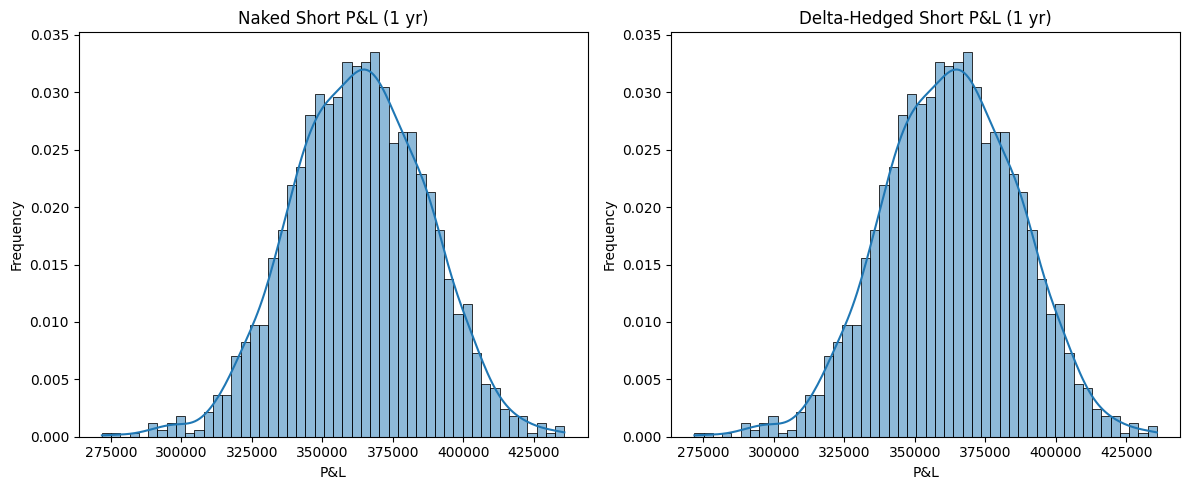

Naked short:    1-yr 99% VaR = $-306,046.06, ES = $-293,463.01
Delta-hedged:   1-yr 99% VaR = $-306,046.06, ES = $-293,463.01


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Market and contract inputs:
initial_spot  = 5633.0
mu            = 0.0453 #real-world expected return (used for P&L sim)
sigma         = 0.0978
short_rate_bp = 49.44
r             = short_rate_bp / 10000
cap, floor    = 0.07, 0.03
notional      = 10_000_000
tau, steps    = 5, 5 #5-year maturity with annual fixings

# Pricing function:
def MC_CliquetPrice(N, S, r, tau, sigma, steps, cap, floor, notional, seed=42):
    scenarios = BSMScenarios(N, S, r, tau, sigma, steps, seed) #simulate coupon scenarios
    coupon_pvs = np.apply_along_axis(CliquetPayoff, 1, scenarios, cap, floor, notional)
    coupon_price   = np.exp(-r * tau) * coupon_pvs.mean() #discounted avg coupon sum
    principal_price = notional * np.exp(-r * tau) #add PV of principal
    return coupon_price + principal_price

# Simulation sizes:
PnL_sims  = 2_000    #number of outer scenarios in which we simulate the 1-year real-world index paths
inner_sim =   200    #number of inner simualations which are used to reprice the contract at t=0 and t=1
days      = 252      # trading days per year

# Compute V0 [current value of 5-year contract using 200-path MC]
V0 = MC_CliquetPrice(inner_sim, initial_spot, r, tau, sigma, steps, cap, floor, notional, seed=2024)

# Simulate S1 [index level after 1 year using real-world terminal prices (under μ)]
# Outer loop begins here, simulating 2000 possible 1-year S&P 500 outcomes
dt    = 1/days
rng   = np.random.default_rng(2024)
Z     = rng.standard_normal((PnL_sims, days))
drift = (mu - 0.5 * sigma**2) * dt
diff  = sigma * np.sqrt(dt) * Z
log_paths = np.concatenate([np.zeros((PnL_sims,1)), np.cumsum(drift + diff, axis=1)], axis=1)
S1 = initial_spot * np.exp(log_paths[:, -1]) #index value at the end of year 1

# Compute V1 [value of the remaining 4-year contract for each path]
# For each of the 2000 final index levels from above (outer loop), we reprice the 4-year cliquet using 200-path MC simualation (inner loop)
V1 = np.array([MC_CliquetPrice(inner_sim, s1, r, tau-1, sigma, steps-1, cap, floor, notional, seed=2025+i)
    for i, s1 in enumerate(S1)])

# Compute P&L from a short position
# We originally sold the contract fro V0. After one year, it's worth V1. So our P&L = -(V1 - V0). This implies we lose money if the value goes up.
PnL_naked  = -(V1 - V0)
PnL_hedged = PnL_naked.copy()   # since Δ≈0, hedged equals naked

# Plot histograms of 1-year P&L distributions
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.histplot(PnL_naked, bins=50, kde=True, stat="frequency", edgecolor='black')
plt.title("Naked Short P&L (1 yr)")
plt.xlabel("P&L")

plt.subplot(1,2,2)
sns.histplot(PnL_hedged, bins=50, kde=True, stat="frequency", edgecolor='black')
plt.title("Delta-Hedged Short P&L (1 yr)")
plt.xlabel("P&L")

plt.tight_layout()
plt.show()

# Compute historical 99% VaR & ES
def historical_var_es(pnls, level=0.99):
    alpha  = 1 - level #1% tail
    thresh = np.percentile(pnls, 100 * alpha) #1st percentile value(loss)
    var    = -thresh #VaR = worst loss not exceeded 99% of the time
    es     = -pnls[pnls <= thresh].mean() #Expected shortfall = average loss beyond VaR
    return var, es

var_n, es_n = historical_var_es(PnL_naked,  level=0.99)
var_h, es_h = historical_var_es(PnL_hedged, level=0.99)

print(f"Naked short:    1-yr 99% VaR = ${var_n:,.2f}, ES = ${es_n:,.2f}")
print(f"Delta-hedged:   1-yr 99% VaR = ${var_h:,.2f}, ES = ${es_h:,.2f}")
